# Heart Disease Diagnosis - A Classification Task

## The Problem

Identifying the presence of a condition in patients can be viewed as a classification task. A certain condition (heart disease, diabetes or cancer) is either **present (1)** in a patient or **absent (0)** from that patient. Since these are diagnostic tools, it is critically important to focus on **minimizing False Negatives**. We cannot build diagnostic tools that predict the **absence** of a condition when the ground truth is otherwise, an undiagnosed condition could delay treatment and be fatal to the patient. Since **False Negatives** are inversely proportional to **Recall**, our goal is to maximize the recall of our model.

## Importing the libraries

In [7]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

plt.rcParams.update({'figure.figsize':(16, 9), 'figure.dpi':60})

## Importing the Data

In [8]:
os.chdir('..')

In [9]:
DATA_PATH = os.getcwd() + '//'
fname = 'heart.csv'

In [10]:
heart_df = pd.read_csv(DATA_PATH + fname, header = 'infer')
heart_df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## The Data

The date is a modified version of the [UCI Heart Disease dataset](http://archive.ics.uci.edu/ml/datasets/heart+disease), also known as the Cleveland Dataset.

The `num` field refers to the presence of heart disease in the patient and is our **target** variable. It is derived from the `goal` variable in the original dataset, an integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish **presence** (values 1,2,3,4) from **absence** (value 0).

**Attribute Information:**

The 14 attributes used that make up this dataset: 
1. `age` : age in years 
2. `sex` : sex 
    * `1` : male
    * `0` : female 
3. `cp` : chest pain type 
    * `1` : typical angina 
    * `2` : atypical angina 
    * `3` : non-anginal pain 
    * `4` : asymptomatic
4. `trestbps` : resting blood pressure (in mm Hg on admission to the hospital) 
5. `chol` : serum cholestoral in mg/dl 
6. `fbs` : (fasting blood sugar > 120 mg/dl) 
    * `1` : true
    * `0` : false
7. `restecg` : resting electrocardiographic results 
    * `0` : normal 
    * `1` : having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    * `2` : showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. `thalach` : maximum heart rate achieved 
9. `exang` : exercise induced angina
    * `1` : yes
    * `0` : no
10. `oldpeak` : ST depression induced by exercise relative to rest 
11. `slope` : the slope of the peak exercise ST segment 
    * `1` : upsloping 
    * `2` : flat 
    * `3` : downsloping
12. `ca` : number of major vessels (0-3) colored by flourosopy 
13. `thal` : 
    * `3` : normal
    * `6` : fixed defect
    * `7` : reversable defect
14. `target` (**target**) : diagnosis of heart disease (angiographic disease status) 
    * `0` : < 50% diameter narrowing 
    * `1` : > 50% diameter narrowing

## Exploratory Data Analysis

In [11]:
heart_df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

While all of the 14 variables are encoded as numeric data, the following variables are categorical in nature : 
 *  `sex`
 *  `cp`
 *  `fbs`
 *  `restecg`
 *  `exang`
 *  `slope`
 *  `thal`
 *  `target`

In [12]:
heart_df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In our dataset, we have 303 examples, 165 (54%) show **presence** of heart disease. The dataset does show some slight imbalance in the class distribution (54/46) and we will take that into account when building our classification model.

Let us look at some plots to explore the visual relationships between the predictive features and the response. One way to get a better understanding of the data is to look at `age` and `sex` and ask the question, *What role do `age` and `sex` play in the prevalence of heart disease?*

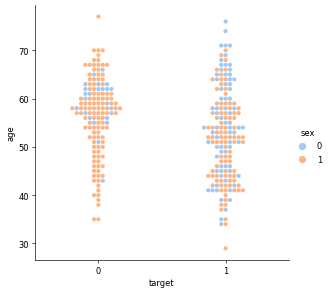

In [13]:
sns.catplot(x="target", y="age", hue="sex", kind="swarm", data=heart_df, palette="pastel")

The above graph is a categorical scatterplot which plots the `target` against `age` and `sex`. Since, this is a dataset where the majority class does have the disease, we can see that people who do have heart disease are well spread out across the `age` spectrum. `sex` on the other hand is a more interesting dimension. The minority class of people who do not have heart disease is dominated by men and has very few women (mostly women in their 50s or 60s), whereas the majority class has a more even spread. This may indicate that women may be more likely to have heart disease. We can explore that as follows : 

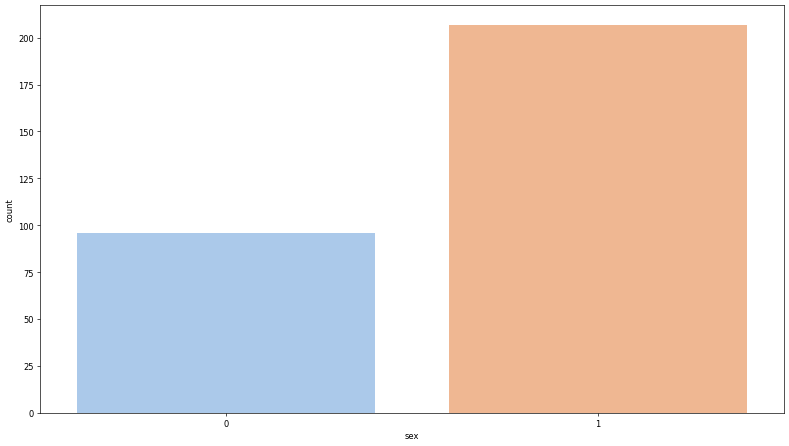

In [22]:
sns.countplot(x="sex", data=heart_df, palette="pastel")

Our dataset is skewed from a gender perspective. Men outnumber women by a ratio of 2:1. Because there is such a high number of men, it is no surprise that on first glance, they dominate the sub-population of people who do not have the disease. Let's explore further.

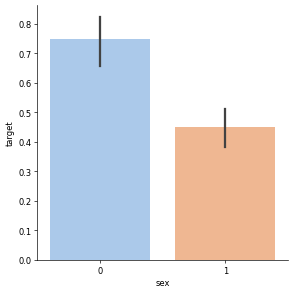

In [23]:
sns.catplot(x="sex", y="target", kind="bar", data=heart_df, palette="pastel")

As we can clearly see here, having `sex == 1` seems to imply a lower chance of having heart disease.

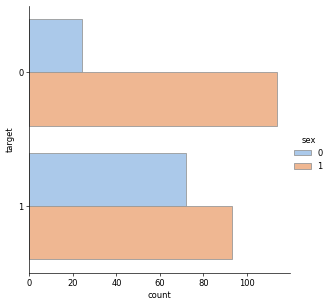

In [24]:
sns.catplot(y="target", hue="sex", kind="count",
            palette="pastel", edgecolor=".6",
            data=heart_df)

The sub-population of people who do not have the disease (`target == 0`) is dominated by men. Interestingly, the sub-population of people who do have the disease is also dominated by men. As we have seen before, men outnumber women by 2:1 in this dataset. To have a fair comparison between the two sub-populations we must look at incidence rates of the disease in the 2 sub-populations.

In [28]:
df_men = heart_df[heart_df['sex'] == 1]
print("Incidence :: Men ->", df_men[df_men['target'] == 1].shape[0]/df_men.shape[0]) ## number of men with the disease/number of men
df_women = heart_df[heart_df['sex'] == 0]
print("Incidence :: Women ->", df_women[df_women['target'] == 1].shape[0]/df_women.shape[0]) ## number of women with the disease/number of women

Incidence :: Men -> 0.4492753623188406
Incidence :: Women -> 0.75


The above snippet quite clearly shows that the Incidence of heart disease for women in our sample is higher than that for men. This may be because of **Bias** as women are under-represented in our data. The only solution to this problem is to have a more gender balanced dataset. Otherwise our machine will end up learning that 75% of women have heart disease, which is inherently incorrect. Such biases can reduce trust in critical diagnostic tools and must be rectified.

Unfortunately, since we do not have more data, we can only continue with our analysis. Let us explore the important features of **blood pressure** (`trestbps`), **cholesterol** (`chol`) and **blood sugar** (`fbs`) and see what impact they have on the absence or presence of heart disease. 

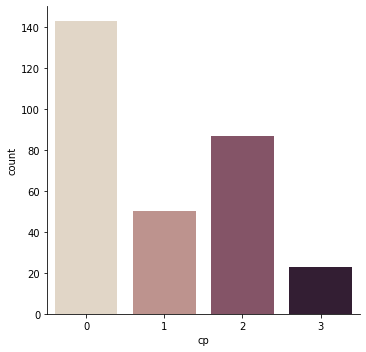

In [12]:
sns.catplot(x="cp", kind="count", palette="ch:.25", data=heart_df)

[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Frequency Histogram')]

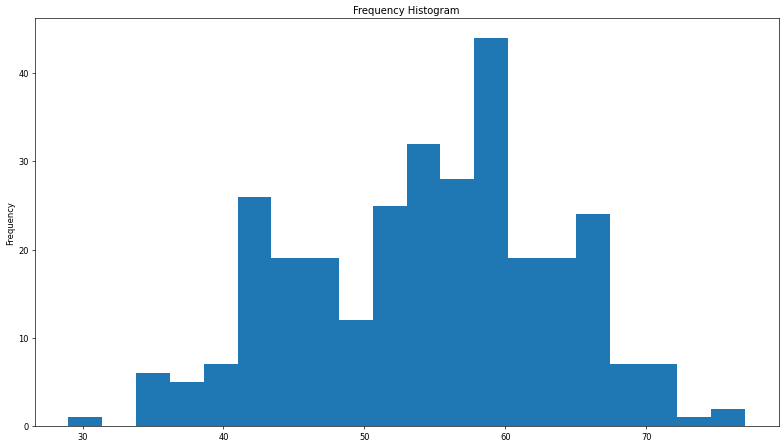

In [26]:
plt.hist(heart_df['age'], bins=20)
plt.gca().set(title='Age', ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Resting Blood Pressure')]

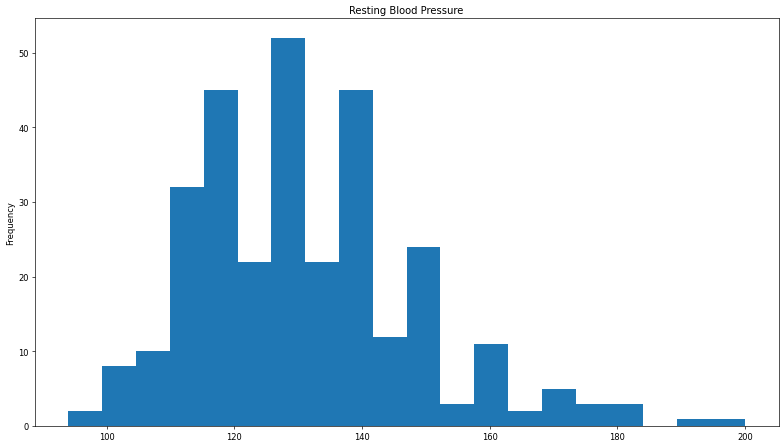

In [28]:
plt.hist(heart_df['trestbps'], bins=20)
plt.gca().set(title='Resting Blood Pressure', ylabel='Frequency')

In [ ]:
trestbps

## Data Pre-Processing

No need for one hot encoding as all features are numeric and there is no class imbalance in the dataset either.

In [8]:
X = heart_df.iloc[:, :-1].values
y = heart_df.iloc[:, -1].values

### Train-Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 0)

In [10]:
print(X_train.shape)

(227, 13)


In [11]:
print(y_train.shape)

(227,)


### Feature Scaling

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
print(X_train.shape)

(227, 13)


In [14]:
print(X_test.shape)

(76, 13)


## Fitting the Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# log_reg = LogisticRegression(random_state=0, class_weight = {0:.45, 1:.55}) ## With class_weights
log_reg = LogisticRegression(random_state=0) ## Without class_weights
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.45, 1: 0.55}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = log_reg.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [18]:
y_test

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

In [19]:
predicted_probabilities = log_reg.predict_proba(X_test)
predicted_probabilities[:, 0] ## Probability of having target == 1

array([0.95143139, 0.16484276, 0.16228557, 0.97272299, 0.84138009,
       0.55419639, 0.90497211, 0.86110357, 0.993019  , 0.99520492,
       0.21950174, 0.04996334, 0.95319187, 0.14461342, 0.0255242 ,
       0.26534823, 0.91104505, 0.2514785 , 0.98801717, 0.20722862,
       0.17402228, 0.63811624, 0.86866272, 0.82188465, 0.10575493,
       0.29728492, 0.77219375, 0.58776365, 0.0140374 , 0.28018682,
       0.31228939, 0.97780459, 0.02568585, 0.25093773, 0.06628511,
       0.27036383, 0.94563409, 0.14763423, 0.91453859, 0.79978769,
       0.20639728, 0.14282402, 0.49635783, 0.8984724 , 0.36886517,
       0.23681745, 0.16686055, 0.32745922, 0.93381282, 0.17862303,
       0.14001998, 0.26684971, 0.02112609, 0.10763345, 0.00379735,
       0.85807681, 0.03343725, 0.052151  , 0.21807921, 0.03405738,
       0.17487543, 0.01030199, 0.05281815, 0.09676405, 0.17042499,
       0.27659131, 0.13809706, 0.77439522, 0.23154261, 0.39667479,
       0.52739795, 0.04852317, 0.15345091, 0.9475188 , 0.87783

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("CONFUSION MATRIX \n", cm)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY :", round(acc, 2))
precision = precision_score(y_test, y_pred)
print("PRECISION :", round(precision, 2))
recall = recall_score(y_test, y_pred)
print("RECALL :", round(recall, 2))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print("AUC : ", round(auc_score, 2))

CONFUSION MATRIX 
 [[24  9]
 [ 3 40]]
ACCURACY : 0.84
PRECISION : 0.82
RECALL : 0.93
AUC :  0.83


Our logistic regression model, performs quite well on this test dataset. As we are diagnosing heart disease, it is critically important to reduce False Negatives (i.e. Predicting an absence of the disease when in reality there is heart disease) => we must **maximize** recall.

Text(0.5, 1.0, 'ROC-CURVE & AREA UNDER CURVE')

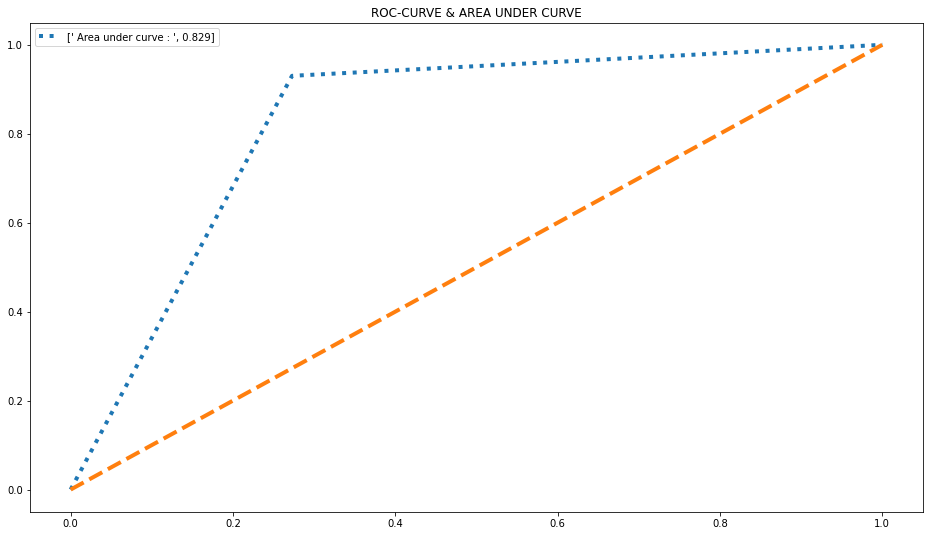

In [21]:
fig = plt.figure(figsize=(16, 9))
ax  = fig.add_subplot(111)
ax.plot(fpr, tpr, label = [" Area under curve : ", round(auc_score, 3)], linewidth = 4, linestyle = "dotted")
ax.plot([0,1],[0,1],linewidth = 4, linestyle = "dashed")
plt.legend(loc = "best")
plt.title("ROC-CURVE & AREA UNDER CURVE")